In [136]:
import chainer
from chainer import Variable
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.optimizers import RMSProp

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


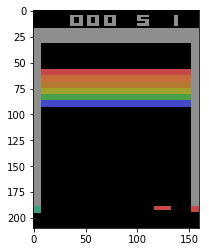

In [138]:
import gym


class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

env = gym.make('Breakout-v0')
print(env.unwrapped.get_action_meanings())

n_iter = 5
agent = RandomAgent(env.action_space)

env = gym.make('Breakout-v0')
obs = env.reset()  # reset environment and agent
reward = None
done = False
R = []

for step in range(n_iter):
    plt.imshow(env.render(mode='rgb_array'))
    action = agent.act(obs, reward, done)
    _obs, reward, done, _ = env.step(action)
    obs = _obs
    R.append(reward)

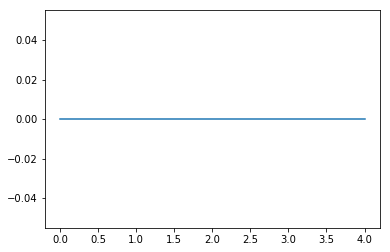

In [139]:
plt.plot(np.cumsum(R))

In [140]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.low[0][0])
print(env.observation_space.high[0][0])

Discrete(4)
Box(210, 160, 3)
[0 0 0]
[255 255 255]


In [141]:
env.observation_space.low.size
env.action_space.n

4

In [142]:
class MLP(Chain):
    
    def __init__(self, obs_size, n_units=64):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_units)
            self.l1 = L.Linear(n_units, 2 * n_units)
            self.l2 = L.Linear(2 * n_units, n_units)
            
    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return F.relu(self.l2(h))  

In [143]:
class ActorCritic(Chain):
    
    def __init__(self, shared_model, n_actions):
        super(ActorCritic, self).__init__()
        with self.init_scope():
            self.shared_model = shared_model
            
            self.actor = L.Linear(None, n_actions)
            self.critic = L.Linear(None, 1)
    
    
    def __call__(self, x):
        h = self.shared_model(x)
    
        pi = F.softmax(self.actor(h))
        v = self.critic(h)
        return pi, v

In [144]:
AC = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)

In [145]:
AC(frame_preprocessor(obs))

(variable([[ 0.26258507,  0.26294535,  0.23586331,  0.23860621]]),
 variable([[-0.15567851]]))

In [146]:
obs_shape = (2,3)
a = np.zeros([2 + 1, 5] + list(obs_shape))
print(a.shape, a.reshape([-1] + list(a.shape)).shape)

(3, 5, 2, 3) (1, 3, 5, 2, 3)


_compute_returns illustration

In [147]:
update_steps = 5
gamma = 0.99
returns = np.zeros(update_steps + 1)
rewards = [1, 1, 1, 1, 1]
next_val = 9
returns[-1] = next_val 
for i in reversed(range(update_steps)):
    returns[i] = rewards[i] + gamma * returns[i + 1]

print(returns)

[ 13.45990546  12.58576309  11.702791    10.8109       9.91         9.        ]


In [159]:
a = np.zeros((1,4))
a.flatten().shape

(4,)

In [177]:
class A2CAgent(object):
    
    def __init__(self, model, optimizer, n_steps, gamma, phi=lambda x: x, 
                 pi_loss_coef=1.0, v_loss_coef=0.5,
                ):
        
        self.model = model
        self.optimizer = optimizer
        self.n_steps = n_steps
        self.gamma = gamma
        self.phi = phi
    
        self.step = 0
        self.start_step = 0
    
    def _compute_returns(self, next_value):
        
        self.returns[-1] = next_value
        for i in reversed(range(self.update_steps)):
            self.returns[i] = self.rewards[i] + \
                self.gamma * self.returns[i + 1]
    
    def _reset_storage(self, state):
        
#         self.states = self.xp.zeros(
#             [self.update_steps + 1, self.num_processes] + list(obs_shape),
#             dtype='f')
#         self.actions = self.xp.zeros(
#             [self.update_steps, self.num_processes] + list(action_shape),
#             dtype=action.dtype)
#         self.rewards = self.xp.zeros(
#             (self.update_steps, self.num_processes, 1), dtype='f')
#         self.value_preds = self.xp.zeros(
#             (self.update_steps + 1, self.num_processes, 1), dtype='f')
#         self.returns = self.xp.zeros(
#             (self.update_steps + 1, self.num_processes, 1), dtype='f')

        self.states = np.zeros((self.n_steps + 1,) + state.shape)
        self.action_log_probs = np.zeros(self.n_steps)
        self.rewards = np.zeros(self.n_steps)
        self.value_preds = np.zeros(self.n_steps + 1)
        self.returns = np.zeros(self.n_steps + 1)
    
    def update(self):
        #print(len(self.states), len(self.actions), len(self.rewards), len(self.value_preds), len(self.returns))
        
        _, next_value = self.model(self.states[-1])
        next_value = next_value.data

        self._compute_returns(next_value)
#         pout, values = \
#             self.model.pi_and_v(chainer.Variable(
#                 self.states[:-1].reshape([-1] + list(self.obs_shape))))
        p_out, values = self.model(chainer.Variable(self.states[:-1]))

#         actions = chainer.Variable(
#             self.actions.reshape([-1] + list(self.action_shape)))
#         dist_entropy = F.mean(pout.entropy)
#         action_log_probs = pout.log_prob(actions)
        # dist_entropy = ???
        
#         values = values.reshape(self.update_steps, self.num_processes, 1)
#         action_log_probs = action_log_probs.reshape(
#             self.update_steps, self.num_processes, 1)
#         advantages = chainer.Variable(self.returns[:-1]) - values
        advantages = chainer.Variable(self.returns[:-1]) - values
        value_loss = F.mean(advantages * advantages)
        action_loss = - F.mean(chainer.Variable(advantages.data) * action_log_probs)
        
        self.model.cleargrads()

        (value_loss * self.v_loss_coef +
         action_loss * self.pi_loss_coef).backward()
         # - dist_entropy * self.entropy_coeff).backward()

        self.optimizer.update()
        self.states[0] = self.states[-1]

        # Update stats
#         self.average_actor_loss += (
#             (1 - self.average_actor_loss_decay) *
#             (float(action_loss.data) - self.average_actor_loss))
#         self.average_value += (
#             (1 - self.average_value_decay) *
#             (float(value_loss.data) - self.average_value))
#         self.average_entropy += (
#             (1 - self.average_entropy_decay) *
#             (float(dist_entropy.data) - self.average_entropy))
        self.start_step = self.step
    
    
    def act_and_train(self, state, reward, done):

#         statevar = self.batch_states([state], self.xp, self.phi)[0]
        state = self.phi(state)
        
        if self.step == 0:
#             pout, _ = self.model.pi_and_v(statevar[0:1])
#             action = pout.sample().data
            p_out, _ = self.model(state)
            action = np.random.choice(n_actions, p=p_out.data.flatten())
            self._reset_storage(state)
        
#         self.rewards[self.t - self.t_start -1] \
#             = self.xp.array(reward, dtype=self.xp.float32)
#         self.states[self.t - self.t_start] = statevar
    
        # self.rewards.append(reward)
        self.rewards[self.step - self.start_step] = np.array(reward, dtype=np.float32)
        # self.states.append(state)
        self.states[self.step - self.start_step] = state

        if self.step - self.start_step == self.n_steps:
            self.update()
            
        p_out, value = self.model(state)
        action = np.random.choice(n_actions, p=p_out.data.flatten())
        # action = env.action_space.sample()  # random
        
#         self.actions[self.t - self.t_start] \
#             = action.reshape([-1] + list(self.action_shape))
#         self.value_preds[self.t - self.t_start] = value.data
        self.action_log_probs = F.log(p_out)
        # self.actions.append(action) 
        self.value_preds[self.step - self.start_step] = value.data
        # self.value_preds.append(0)

        self.step += 1
            
        return action
        # return env.action_space.sample()  # random
    
    def act(self, obs):

        pass

Sample an action given probabilites.

In [178]:
n_actions = 4
probs = [0.1, 0.2, 0.3, 0.4]

np.random.choice(4, 10, p=probs)

array([3, 3, 3, 3, 2, 3, 3, 1, 3, 3])

In [179]:
env = gym.make('Breakout-v0')
print(env.action_space)
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

frame_preprocessor = lambda x: (x.astype(np.float32) / 255).reshape([-1] + list(x.shape))
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

# print("states actions rewards value_preds returns")

obs = env.reset()
reward = 0
done = False
R = []

for _ in range(50):
    #plt.imshow(env.render(mode='rgb_array'))
    action = agent.act_and_train(obs, reward, done)
    _obs, reward, done, _ = env.step(action)
    obs = _obs
    R.append(reward)

plt.plot(np.cumsum(R))

Discrete(4)


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
type(action)

In [ ]:
n_episodes = 200
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

In [ ]:
import logging
import sys
gym.undo_logger_setup()  # Turn off gym's default logger settings
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

chainerrl.experiments.train_agent_with_evaluation(
    agent, env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_runs=10,       # 10 episodes are sampled for each evaluation
    max_episode_len=200,  # Maximum length of each episodes
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result')      # Save everything to 'result' directory

In [ ]:
class QFunction(chainer.Chain):

    def __init__(self, obs_size, n_actions, n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l2 = L.Linear(n_hidden_channels, n_actions)

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
        """
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

In [ ]:
import chainer 
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

from chainer import cuda

import datetime
from skimage.color import rgb2gray
from skimage.transform import resize

env = gym.make('Breakout-v0')
obs = env.reset()

print("observation space   : {}".format(env.observation_space))
print("action space        : {}".format(env.action_space))

action = env.action_space.sample()
obs, r, done, info = env.step(action)
class QFunction(chainer.Chain):
def __init__(self,obs_size, n_action):
    super(QFunction, self).__init__(
        l1=L.Convolution2D(obs_size, 4, ksize=2,pad=1),#210x160
        bn1=L.BatchNormalization(4),
        l2=L.Convolution2D(4, 4, ksize=2,pad=1),#105x80
        bn2=L.BatchNormalization(4),
        #l3=L.Convolution2D(64, 64, ksize=2, pad=1),#100x100
        #bn3=L.BatchNormalization(64),
        #l4=L.Convolution2D(64, 3, ksize=2,pad=1),#50x50
       # bn4=L.BatchNormalization(3),

        l5=L.Linear(972, 512),
        out=L.Linear(512, n_action, initialW=np.zeros((n_action, 512), dtype=np.float32))
    )

def __call__(self, x, test=False):

    h1=F.relu(self.bn1(self.l1(x)))
    h2=F.max_pooling_2d(F.relu(self.bn2(self.l2(h1))),2)
    #h3=F.relu(self.bn3(self.l3(h2)))
    #h4=F.max_pooling_2d(F.relu(self.bn4(self.l4(h3))),2)
    #print h4.shape

    return chainerrl.action_value.DiscreteActionValue(self.out(self.l5(h2)))

n_action = env.action_space.n
obs_size = env.observation_space.shape[0] #(210,160,3)
q_func = QFunction(obs_size, n_action)

optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

gamma = 0.99

explorer = chainerrl.explorers.ConstantEpsilonGreedy(
epsilon=0.2, random_action_func=env.action_space.sample)

replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

phi = lambda x: x.astype(np.float32, copy=False)
agent = chainerrl.agents.DoubleDQN(
q_func, optimizer, replay_buffer, gamma, explorer,
minibatch_size=4, replay_start_size=100, update_interval=10,
target_update_interval=10, phi=phi)

last_time = datetime.datetime.now()
n_episodes = 10000
for i in range(1, n_episodes + 1):
obs = env.reset()

reward = 0
done = False
R = 0

while not done:
    env.render()
    action = agent.act_and_train(obs, reward)
    obs, reward, done, _ = env.step(action)


    if reward != 0:
        R += reward

elapsed_time = datetime.datetime.now() - last_time
print('episode:', i, 
      'reward:', R,
     )
last_time = datetime.datetime.now()

if i % 100 == 0:
    filename = 'agent_Breakout' + str(i)
    agent.save(filename)

agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

Layer freezing.

In [29]:
class CNN(chainer.Chain):
    
    def __init__(self, train=True):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 1, 1, initialW=np.array([[[[1]]]])) ,
            l1 = L.Linear(None, 1, initialW=np.array([[1,1,1,1]]))  
        )

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.sigmoid(self.l1(h))
        return h


net = CNN()
net.cleargrads()
optimizer = chainer.optimizers.SGD()
optimizer.setup(net)

optimizer.setup(net)
net.conv1.W.update_rule.enabled = False
# net.conv1.disable_update()  # also works

result = net(np.random.random((1,1,2,2)).astype(np.float32))
print("conv1 weights:",net.conv1.W.data)
print("l1 weigths:",net.l1.W.data)
loss = F.mean_absolute_error(result,np.array([[0.1]],dtype=np.float32))
loss.backward()
optimizer.update()
print("conv1 grad",net.conv1.W.grad)
print("after update...")
print("conv1 weights:",net.conv1.W.data)
print("l1 weights:",net.l1.W.data)

conv1 weights: [[[[ 1.]]]]
l1 weigths: [[ 1.  1.  1.  1.]]
conv1 grad [[[[ 0.19457532]]]]
after update...
conv1 weights: [[[[ 1.]]]]
l1 weights: [[ 0.99955279  0.99984294  0.99892896  0.99972951]]


pyTorch tutorial

In [ ]:
import gym
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

In [ ]:
# Discount factor. Model is not very sensitive to this value.
GAMMA = .95

# LR of 3e-2 explodes the gradients, LR of 3e-4 trains slower
LR = 3e-3
N_GAMES = 2000

# OpenAI baselines uses nstep of 5.
N_STEPS = 20

env = gym.make('CartPole-v0')
N_ACTIONS = 2 # get from env
N_INPUTS = 4 # get from env

model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
state = env.reset()
finished_games = 0

while finished_games < N_GAMES:
    states, actions, rewards, dones = [], [], [], []

    # Gather training data
    for i in range(N_STEPS):
        s = Variable(torch.from_numpy(state).float().unsqueeze(0))

        action_probs = model.get_action_probs(s)
        action = action_probs.multinomial().data[0][0]
        next_state, reward, done, _ = env.step(action)

        states.append(state); actions.append(action); rewards.append(reward); dones.append(done)

        if done: state = env.reset(); finished_games += 1
        else: state = next_state

    # Reflect on training data
    reflect(states, actions, rewards, dones)

In [ ]:
def calc_actual_state_values(rewards, dones):
    R = []
    rewards.reverse()

    # If we happen to end the set on a terminal state, set next return to zero
    if dones[-1] == True: next_return = 0
        
    # If not terminal state, bootstrap v(s) using our critic
    # TODO: don't need to estimate again, just take from last value of v(s) estimates
    else: 
        s = torch.from_numpy(states[-1]).float().unsqueeze(0)
        next_return = model.get_state_value(Variable(s)).data[0][0] 
    
    # Backup from last state to calculate "true" returns for each state in the set
    R.append(next_return)
    dones.reverse()
    for r in range(1, len(rewards)):
        if not dones[r]: this_return = rewards[r] + next_return * GAMMA
        else: this_return = 0
        R.append(this_return)
        next_return = this_return

    R.reverse()
    state_values_true = Variable(torch.FloatTensor(R)).unsqueeze(1)
    
    return state_values_true

In [ ]:
def reflect(states, actions, rewards, dones):
    
    # Calculating the ground truth "labels" as described above
    state_values_true = calc_actual_state_values(rewards, dones)

    s = Variable(torch.FloatTensor(states))
    action_probs, state_values_est = model.evaluate_actions(s)
    action_log_probs = action_probs.log() 
    
    a = Variable(torch.LongTensor(actions).view(-1,1))
    chosen_action_log_probs = action_log_probs.gather(1, a)

    # This is also the TD error
    advantages = state_values_true - state_values_est

    entropy = (action_probs * action_log_probs).sum(1).mean()
    action_gain = (chosen_action_log_probs * advantages).mean()
    value_loss = advantages.pow(2).mean()
    total_loss = value_loss - action_gain - 0.0001*entropy

    optimizer.zero_grad()
    total_loss.backward()
    nn.utils.clip_grad_norm(model.parameters(), 0.5)
    optimizer.step()

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.linear1 = nn.Linear(N_INPUTS, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 64)
        
        self.actor = nn.Linear(64, N_ACTIONS)
        self.critic = nn.Linear(64, 1)
    
    # In a PyTorch model, you only have to define the forward pass. PyTorch computes the backwards pass for you!
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x) 
        return x
    
    # Only the Actor head
    def get_action_probs(self, x):
        x = self(x)
        action_probs = F.softmax(self.actor(x))
        return action_probs
    
    # Only the Critic head
    def get_state_value(self, x):
        x = self(x)
        state_value = self.critic(x)
        return state_value
    
    # Both heads
    def evaluate_actions(self, x):
        x = self(x)
        action_probs = F.softmax(self.actor(x))
        state_values = self.critic(x)
        return action_probs, state_values

In [ ]:
def test_model(model):
    score = 0
    done = False
    env = gym.make('CartPole-v0')
    state = env.reset()
    global action_probs
    while not done:
        score += 1
        s = torch.from_numpy(state).float().unsqueeze(0)
        
        action_probs = model.get_action_probs(Variable(s))
        
        _, action_index = action_probs.max(1)
        action = action_index.data[0] 
        next_state, reward, done, thing = env.step(action)
        state = next_state
    return score

In [ ]:
test_model(model)